# Project: Investigate a Dataset - [European Socccer Database]

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling Soccer Database</a></li>
<li><a href="#part2">Web Scraping and Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

It contains data for football matches, players, and teams from 11 European countries and their respective top leagues from 2008 to 2016. 

I will work both the dataset and external data I will get from the web for league tables.

While I can make league tables on my own, there are enough rule differences, tie-breakers and sometimes even change in league format that I wanted to use other tools to get these tables, which summarize each season for each league.

I will focus on the top 4 european leagues according to UEFA ranking. These are England, Spain, Italy and German leagues.
These leagues are the only leagues to keep their places within this range. I will also very likely see a large proportion of matches without missing data as these are the leagues with most available match data, both historical and recent.

### Question(s) for Analysis
I want to look at how different variables work in relationship to create the best and worst performing teams.  
If there is a consistency between the leagues in the approach to the game.  
And lastly who the best performing teams are through the period we have in the dataset.  

I will also look at home and away performance and if there is different approach from teams, as well as performance in general.

<a id='wrangling'></a>
## Data Wrangling: Match Data



### General Properties
The Data is on matches played in England, Italy, Germany, and Spains top football divisions between 2008 and 2016.  
Each match has home and away team (prefix h_ or a_).  
* 'league_id' - id of the league or country
* season - the season the match was played in, formatted as '2008/2009' 
* stage - 34 games pr team in Germany, and 38 in the 3 other nations
* date - date of the match
* match_api_id, home_team_api_id, away_team_api_id - id for the match, home team and away team
* h_name, a_name - names of home and away teams
* home_team_goal, away_team_goal, goal - home and away teams goals in number, and match goals in XML format
* shoton - shot on target recorded in the match
* shotoff - shot off target
* foulcommit - fouls committed
* card - cards received by players during the match
* cross - crosses in the game
* corner - corners in the game
* possession - percentage of the time each team kept the ball in their control

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xml.etree.ElementTree as et


#### Read match data and turn xml columns into team values.

In [2]:
file = "data/match_xml.csv"
m_df = pd.read_csv(file)

In [3]:
m_df.head()

,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,h_name,a_name,home_team_goal,away_team_goal,goal,shoton,shotoff,foulcommit,card,cross,corner,possession
0,1729,2008/2009,1,2008-08-17 00:00:00,489042,10260,10261,Manchester United,Newcastle United,1,1,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>56</comment><event...
1,1729,2008/2009,1,2008-08-16 00:00:00,489043,9825,8659,Arsenal,West Bromwich Albion,1,0,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card />,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>65</comment><event...
2,1729,2008/2009,1,2008-08-16 00:00:00,489044,8472,8650,Sunderland,Liverpool,0,1,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>45</comment><event...
3,1729,2008/2009,1,2008-08-16 00:00:00,489045,8654,8528,West Ham United,Wigan Athletic,2,1,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>50</comment><event...
4,1729,2008/2009,1,2008-08-17 00:00:00,489046,10252,8456,Aston Villa,Manchester City,4,2,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><corners>1</corners></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>51</comment><event...


In [74]:
#from IPython.core.debugger import set_trace
#import pdb
def xml_str(xml):
    try:
        return et.fromstring(xml)
    except:
        return None
    
def metric_reader(xml, h_team, a_team):
    #read xml and return team home and away sum of values 
    #set_trace()
    if xml == None: return np.nan, np.nan
    if len(xml.findall('value')) == 0: return np.nan, np.nan

    team_metric = xml.findall('value/team')
    teams = [x for x in map(lambda x: int(x.text),team_metric)]
    return teams.count(h_team), teams.count(a_team)

def card_reader(xml, h_team, a_team):
    #xml reader for card column, return home and away sum of values
    #yellow 1 point, red 2 points, fairplay tables use these values to measure
    #how clean teams play
    if xml == None: return np.nan, np.nan
    if len(xml.findall('value')) == 0: return np.nan, np.nan
    
    cards = {
        h_team: 0,
        a_team: 0
    }
    
    for card in xml.findall('value'):
        if card.find('team') == None: continue
        color = card.find('comment').text
        team = int(card.find('team').text)
        if color == 'y':
            cards[team] = cards[team] + 1
        elif color == 'r':
            cards[team] = cards[team] + 2
    return cards[h_team], cards[a_team]

def possession_reader(xml):
    #reader for possession
    if xml == None: return np.nan, np.nan
    if len(xml.findall('value')) == 0: return np.nan, np.nan
    
    return int(xml.findall('value/homepos')[-1].text), (int(xml.findall('value/awaypos')[-1].text))

def call_reader(row, column):
    #call the different readers given a column and the row
    #it's slow as we run this for each column, but it's readable
    h = 'home_team_api_id'
    a ='away_team_api_id'
    
    if column == 'card':
        return card_reader(xml_str(row[column]), row[h], row[a])
    elif column == 'possession':
        return possession_reader(xml_str(row[column]))
    
    return metric_reader(xml_str(row[column]), row[h], row[a])

**We take the xml columns and turn them into values with clean_xml function**

In [31]:
def clean_xml(df, cols):
    h_, a_ = 'home_team_api_id', 'away_team_api_id'
    for col in list(cols.keys()):
        df[['h_' + cols[col], 'a_' + cols[col]]] = df[[col, h_, a_]].apply(lambda row: call_reader(row, col), axis = 1, result_type = 'expand')    
    return df

In [82]:
cols_dict = {
    'shoton': 'SoT', 'shotoff': 'SofT','foulcommit': 'foul', 'card' : 'cards', 'cross': 'crosses', 'corner': 'corners', 'possession': 'pos'}

clean_xml(m_df,  cols_dict)


,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,h_name,a_name,home_team_goal,...,h_foul,a_foul,h_crosses,a_crosses,h_corners,a_corners,h_pos,a_pos,h_cards,a_cards
0,1729,2008/2009,1,2008-08-17 00:00:00,489042,10260,10261,Manchester United,Newcastle United,1,...,16.0,11.0,24.0,9.0,6.0,6.0,55.0,45.0,3.0,0.0
1,1729,2008/2009,1,2008-08-16 00:00:00,489043,9825,8659,Arsenal,West Bromwich Albion,1,...,11.0,9.0,21.0,7.0,7.0,5.0,66.0,34.0,NaN,NaN
2,1729,2008/2009,1,2008-08-16 00:00:00,489044,8472,8650,Sunderland,Liverpool,0,...,13.0,12.0,15.0,19.0,1.0,8.0,46.0,54.0,0.0,2.0
3,1729,2008/2009,1,2008-08-16 00:00:00,489045,8654,8528,West Ham United,Wigan Athletic,2,...,14.0,13.0,15.0,27.0,6.0,10.0,52.0,48.0,2.0,1.0
4,1729,2008/2009,1,2008-08-17 00:00:00,489046,10252,8456,Aston Villa,Manchester City,4,...,11.0,13.0,16.0,16.0,7.0,8.0,52.0,48.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11540,21518,2015/2016,9,2015-10-25 00:00:00,2030167,9906,10267,Atlético Madrid,Valencia CF,2,...,26.0,10.0,13.0,9.0,9.0,2.0,49.0,51.0,4.0,4.0
11541,21518,2015/2016,9,2015-10-24 00:00:00,2030168,9864,9783,Málaga CF,RC Deportivo de La Coruña,2,...,11.0,10.0,20.0,14.0,3.0,5.0,50.0,50.0,0.0,1.0
11542,21518,2015/2016,9,2015-10-26 00:00:00,2030169,8315,9869,Athletic Club de Bilbao,Real Sporting de Gijón,3,...,8.0,15.0,20.0,20.0,9.0,3.0,52.0,48.0,1.0,3.0
11543,21518,2015/2016,9,2015-10-24 00:00:00,2030170,7878,8603,Granada CF,Real Betis Balompié,1,...,8.0,11.0,17.0,6.0,3.0,3.0,45.0,55.0,3.0,3.0


We're missing about 4000 data points on the metric-columns,  
given that we want to look at how teams perform, we still have a lot of datapoints to  
get clear picture of how these things will relate to overall performance.

In [83]:
m_df.describe()

,league_id,stage,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,h_SoT,a_SoT,h_SofT,...,h_foul,a_foul,h_crosses,a_crosses,h_corners,a_corners,h_pos,a_pos,h_cards,a_cards
count,11545.000000,11545.000000,1.154500e+04,11545.000000,11545.000000,11545.000000,11545.000000,7356.000000,7356.000000,7356.000000,...,7358.000000,7358.000000,7358.000000,7358.000000,7357.000000,7357.000000,7316.000000,7316.000000,11212.000000,11212.000000
mean,10457.573062,19.060546,1.205628e+06,9435.838285,9436.094760,1.575054,1.166392,6.243203,4.959081,6.316069,...,12.618646,13.124354,19.066866,14.933406,5.909202,4.559467,51.471569,48.528431,2.133607,2.495630
std,7333.257814,10.766970,4.946744e+05,8135.844725,8135.835406,1.316680,1.145639,3.274604,2.827722,3.043088,...,4.424989,4.465158,8.371465,7.216015,3.039109,2.608943,9.332347,9.332347,1.444228,1.501012
min,1729.000000,1.000000,4.890420e+05,6269.000000,6269.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,17.000000,0.000000,0.000000
25%,1729.000000,10.000000,7.056020e+05,8530.000000,8530.000000,1.000000,0.000000,4.000000,3.000000,4.000000,...,9.000000,10.000000,13.000000,10.000000,4.000000,3.000000,45.000000,42.000000,1.000000,1.000000
50%,10257.000000,19.000000,1.228290e+06,8659.000000,8659.000000,1.000000,1.000000,6.000000,5.000000,6.000000,...,12.000000,13.000000,18.000000,14.000000,6.000000,4.000000,52.000000,48.000000,2.000000,2.000000
75%,21518.000000,28.000000,1.723986e+06,9876.000000,9876.000000,2.000000,2.000000,8.000000,7.000000,8.000000,...,15.000000,16.000000,24.000000,19.000000,8.000000,6.000000,58.000000,55.000000,3.000000,3.000000
max,21518.000000,38.000000,2.060645e+06,208931.000000,208931.000000,10.000000,8.000000,26.000000,19.000000,21.000000,...,32.000000,32.000000,72.000000,59.000000,20.000000,19.000000,83.000000,96.000000,11.000000,11.000000


In [88]:
print(m_df.columns)
m_df.head()

Index(['league_id', 'season', 'stage', 'date', 'match_api_id',
       'home_team_api_id', 'away_team_api_id', 'h_name', 'a_name',
       'home_team_goal', 'away_team_goal', 'goal', 'shoton', 'shotoff',
       'foulcommit', 'card', 'cross', 'corner', 'possession', 'h_SoT', 'a_SoT',
       'h_SofT', 'a_SofT', 'h_foul', 'a_foul', 'h_crosses', 'a_crosses',
       'h_corners', 'a_corners', 'h_pos', 'a_pos', 'h_cards', 'a_cards'],
      dtype='object')


,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,h_name,a_name,home_team_goal,...,h_foul,a_foul,h_crosses,a_crosses,h_corners,a_corners,h_pos,a_pos,h_cards,a_cards
0,1729,2008/2009,1,2008-08-17 00:00:00,489042,10260,10261,Manchester United,Newcastle United,1,...,16.0,11.0,24.0,9.0,6.0,6.0,55.0,45.0,3.0,0.0
1,1729,2008/2009,1,2008-08-16 00:00:00,489043,9825,8659,Arsenal,West Bromwich Albion,1,...,11.0,9.0,21.0,7.0,7.0,5.0,66.0,34.0,NaN,NaN
2,1729,2008/2009,1,2008-08-16 00:00:00,489044,8472,8650,Sunderland,Liverpool,0,...,13.0,12.0,15.0,19.0,1.0,8.0,46.0,54.0,0.0,2.0
3,1729,2008/2009,1,2008-08-16 00:00:00,489045,8654,8528,West Ham United,Wigan Athletic,2,...,14.0,13.0,15.0,27.0,6.0,10.0,52.0,48.0,2.0,1.0
4,1729,2008/2009,1,2008-08-17 00:00:00,489046,10252,8456,Aston Villa,Manchester City,4,...,11.0,13.0,16.0,16.0,7.0,8.0,52.0,48.0,0.0,1.0


###### Keep non xml columns before saving to csv

In [99]:
keep_cols = ['league_id', 'season', 'stage', 'date', 'match_api_id',
       'home_team_api_id', 'away_team_api_id', 'h_name', 'a_name',
       'home_team_goal', 'away_team_goal', 'h_SoT', 'a_SoT',
       'h_SofT', 'a_SofT', 'h_foul', 'a_foul', 'h_crosses', 'a_crosses',
       'h_corners', 'a_corners', 'h_pos', 'a_pos', 'h_cards', 'a_cards']
m_df['date'] = m_df['date'].apply(lambda x: pd.to_datetime(x[:10]))
m_df = m_df[keep_cols]
m_df.head()

,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,h_name,a_name,home_team_goal,...,h_foul,a_foul,h_crosses,a_crosses,h_corners,a_corners,h_pos,a_pos,h_cards,a_cards
0,1729,2008/2009,1,2008-08-17,489042,10260,10261,Manchester United,Newcastle United,1,...,16.0,11.0,24.0,9.0,6.0,6.0,55.0,45.0,3.0,0.0
1,1729,2008/2009,1,2008-08-16,489043,9825,8659,Arsenal,West Bromwich Albion,1,...,11.0,9.0,21.0,7.0,7.0,5.0,66.0,34.0,NaN,NaN
2,1729,2008/2009,1,2008-08-16,489044,8472,8650,Sunderland,Liverpool,0,...,13.0,12.0,15.0,19.0,1.0,8.0,46.0,54.0,0.0,2.0
3,1729,2008/2009,1,2008-08-16,489045,8654,8528,West Ham United,Wigan Athletic,2,...,14.0,13.0,15.0,27.0,6.0,10.0,52.0,48.0,2.0,1.0
4,1729,2008/2009,1,2008-08-17,489046,10252,8456,Aston Villa,Manchester City,4,...,11.0,13.0,16.0,16.0,7.0,8.0,52.0,48.0,0.0,1.0


In [100]:
#m_df.to_csv('match_stats.csv', index=False)

<a id='part2'></a>

## Data Wrangling: Web scraping for League Tables 
##### League Tables from Transfermarkt with BeautifulSoup

#### Find league tables for given country and season 
Use this to analyize relationship between variables and placement in table at the end of the season.

In [ ]:
from bs4 import BeautifulSoup
import requests

In [1]:
path = r'C:\Users\omara\Documents\DatAn\Data Analysis\DAND\proj2\data\\'
target_class = 'responsive-table'
headers = {'User-Agent': 
           'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'}


#### Get links for chosen league tables

In [27]:
def leagueLinks(start = 2008, end = 2016):
    league_link = {}
    league_link['england'] = seasonLink(links['england'], start, end)
    league_link['italy'] = seasonLink(links['italy'], start, end)
    league_link['germany'] = seasonLink(links['germany'], start, end)
    league_link['spain'] = seasonLink(links['spain'], start, end)
    return league_link

def seasonLink(link, start, end):
    if(start > end):
        return []
    return [link+str(start)] + seasonLink(link, start+1, end)

links = {
    'italy': 'https://www.transfermarkt.com/serie-a/tabelle/wettbewerb/IT1?saison_id=',
    'england': 'https://www.transfermarkt.com/premier-league/tabelle/wettbewerb/GB1?saison_id=',
    'spain': 'https://www.transfermarkt.com/laliga/tabelle/wettbewerb/ES1?saison_id=',
    'germany': 'https://www.transfermarkt.com/bundesliga/tabelle/wettbewerb/L1?saison_id='
}

league_tables = {}
league_links = leagueLinks()

##### Get pages with season tables, store the tables, and create season tables dict out of them.

In [3]:
import pprint
pp = pprint.PrettyPrinter(indent=4, width= 100)

def findTable(table):
    match = table.find_all('tr')
    return leagueTable(match)

def leagueTable(tb):
    t = [team.text.split('\n')[1:-1] for team in tb]
    for i in range(len(t)):
        t[i][0] = str(i+1)
    return t

In [36]:
import time

def getPage(page):
    #page = 'https://www.transfermarkt.com/serie-a/tabelle/wettbewerb/IT1?saison_id=2019'
    pageTree = requests.get(page, headers=headers)
    return BeautifulSoup(pageTree.content, 'lxml') #pageSoup

def getTable(pageSoup):
    return findTable (pageSoup.find(class_=target_class).tbody)

def seasonTables(country, links):
    seasons = {}
    country_links = league_links[country]
    for szn in range(len(country_links)):
        season = country_links[szn][-4:]
        seasons[season] = getTable(getPage(country_links[szn]))
        time.sleep(.2)
    return seasons


In [69]:
league_tables['italy'] = seasonTables('italy', league_links)
league_tables['england'] = seasonTables('england', league_links)
league_tables['germany'] = seasonTables('germany', league_links)
league_tables['spain'] = seasonTables('spain', league_links)
pp.pprint(league_tables['spain']['2009'])

[   ['1', '', '', 'Juventus  ', '38', '26', '5', '7', '76:43', '33', '83'],
    ['2', '', '', 'Inter ', '38', '24', '10', '4', '81:36', '45', '82'],
    ['3', '', '', 'Atalanta BC ', '38', '23', '9', '6', '98:48', '50', '78'],
    ['4', '', '', 'Lazio  ', '38', '24', '6', '8', '79:42', '37', '78'],
    ['5', '', '', 'AS Roma ', '38', '21', '7', '10', '77:51', '26', '70'],
    ['6', '', '', 'AC Milan ', '38', '19', '9', '10', '63:46', '17', '66'],
    ['7', '', '', 'SSC Napoli ', '38', '18', '8', '12', '61:50', '11', '62'],
    ['8', '', '', 'Sassuolo ', '38', '14', '9', '15', '69:63', '6', '51'],
    ['9', '', '', 'Hellas Verona \xa0 ', '38', '12', '13', '13', '47:51', '-4', '49'],
    ['10', '', '', 'Fiorentina ', '38', '12', '13', '13', '51:48', '3', '49'],
    ['11', '', '', 'Parma ', '38', '14', '7', '17', '56:57', '-1', '49'],
    ['12', '', '', 'Bologna ', '38', '12', '11', '15', '52:65', '-13', '47'],
    ['13', '', '', 'Udinese Calcio ', '38', '12', '9', '17', '37:51', '-14', '


### Data Cleaning: League Tables

**Remove empty columns, clean names, add season number and save data**

In [162]:
import unicodedata
import json

def savefiles(country,table_):
    with open(country+'.json', 'w+') as f:
        # this would place the entire output on one line
        # use json.dump(lista_items, f, indent=4) to "pretty-print" with four spaces per indent
        json.dump(table_[country], f,  indent=2)

def getfiles(country):
    with open(country+'.json') as f:
        data = json.load(f)
    return data

def cleanSeason(szn, year, country_id):
    season = []
    #remove empty columns, but only if we have all 11 columns still
    for pos in szn:
        if(len(pos) == 11):
           pos.pop(2)
           pos.pop(1)
        #remove trailing string code in names
        pos[1] = unicodedata.normalize('NFD',  pos[1]).replace('\xa0','').strip()
        pos.append(country_id)
        #add seasons 2008/2009 rather than the current 2008 for each season
        pos.append(year+'/'+str(int(year)+1))
        season.append(pos)
    return season

#savefiles('spain')
league_tables2 = league_tables.copy() #doesn't do deep copy

**Clean every season for each league**

In [142]:
country_id = {
    'england': 1729,
    'germany': 7809,
    'italy': 10257,
    'spain': 21518
}

for country in league_tables2:
    for year in league_tables2[country]:
        league_tables2[country][year] = cleanSeason(league_tables2[country][year], year, country_id[country])
pp.pprint(league_tables2['spain']['2008'])

[   ['1', 'Barcelona', '38', '27', '6', '5', '105:35', '70', '87', 21518, '2008/2009'],
    ['2', 'Real Madrid', '38', '25', '3', '10', '83:52', '31', '78', 21518, '2008/2009'],
    ['3', 'Sevilla FC', '38', '21', '7', '10', '54:39', '15', '70', 21518, '2008/2009'],
    ['4', 'Atlético Madrid', '38', '20', '7', '11', '80:57', '23', '67', 21518, '2008/2009'],
    ['5', 'Villarreal', '38', '18', '11', '9', '61:54', '7', '65', 21518, '2008/2009'],
    ['6', 'Valencia', '38', '18', '8', '12', '68:54', '14', '62', 21518, '2008/2009'],
    ['7', 'Dep. La Coruña', '38', '16', '10', '12', '48:47', '1', '58', 21518, '2008/2009'],
    ['8', 'Málaga CF', '38', '15', '10', '13', '55:59', '-4', '55', 21518, '2008/2009'],
    ['9', 'RCD Mallorca', '38', '14', '9', '15', '53:60', '-7', '51', 21518, '2008/2009'],
    ['10', 'Espanyol', '38', '12', '11', '15', '46:49', '-3', '47', 21518, '2008/2009'],
    ['11', 'UD Almería', '38', '13', '7', '18', '45:61', '-16', '46', 21518, '2008/2009'],
    ['1

In [122]:
for country in league_tables2:
    savefiles(country, league_tables2)

In [175]:
#create one dataset and turn it into dataframe and make csv file
def dataList(table):
    #We want to take the individual league tables and join them
    all_list = []
    for country in table:
        for year in table[country]:
            all_list.append(table[country][year])
            
    return all_list
all_seasons = dataList(league_tables2)
all_seasons = sum(all_seasons,[])

In [176]:
def fixgoals(data):
    #goals are in home:away format, change to 2 columns
    for i in range(len(data)):
        data[i] = data[i][:6] + data[i][6].split(':') + data[i][7:]
    return data
all_seasons = fixgoals(all_seasons)
pp.pprint(all_seasons[:22])

[   ['1', 'Inter', '38', '25', '9', '4', '70', '32', '38', '84', 10257, '2008/2009'],
    ['2', 'Juventus', '38', '21', '11', '6', '69', '37', '32', '74', 10257, '2008/2009'],
    ['3', 'AC Milan', '38', '22', '8', '8', '70', '35', '35', '74', 10257, '2008/2009'],
    ['4', 'Fiorentina', '38', '21', '5', '12', '53', '38', '15', '68', 10257, '2008/2009'],
    ['5', 'Genoa', '38', '19', '11', '8', '56', '39', '17', '68', 10257, '2008/2009'],
    ['6', 'AS Roma', '38', '18', '9', '11', '64', '61', '3', '63', 10257, '2008/2009'],
    ['7', 'Udinese', '38', '16', '10', '12', '61', '50', '11', '58', 10257, '2008/2009'],
    ['8', 'US Palermo', '38', '17', '6', '15', '57', '50', '7', '57', 10257, '2008/2009'],
    ['9', 'Cagliari Calcio', '38', '15', '8', '15', '49', '50', '-1', '53', 10257, '2008/2009'],
    ['10', 'Lazio', '38', '15', '5', '18', '46', '55', '-9', '50', 10257, '2008/2009'],
    ['11', 'Atalanta BC', '38', '13', '8', '17', '45', '48', '-3', '47', 10257, '2008/2009'],
    ['12

**More cleaning, and turn data in pandas DataFrame**

In [180]:
column_names = ['position', 'name', 'games', 'win', 'draw', 'loss', 'g_f', 'g_a', 'goal_diff', 'points', 'league_id', 'season']
fb_df = pd.DataFrame(np.array(all_seasons), columns=column_names)
#np.array(all_seasons).shape

**The data is still text, some of these values are numbers, let's change that**

In [201]:
cols = fb_df.columns.drop(['name', 'season'])
fb_df[cols] = fb_df[cols].astype(int)
fb_df.head()

,position,name,games,win,draw,loss,g_f,g_a,goal_diff,points,league_id,season
0,1,Inter,38,25,9,4,70,32,38,84,10257,2008/2009
1,2,Juventus,38,21,11,6,69,37,32,74,10257,2008/2009
2,3,AC Milan,38,22,8,8,70,35,35,74,10257,2008/2009
3,4,Fiorentina,38,21,5,12,53,38,15,68,10257,2008/2009
4,5,Genoa,38,19,11,8,56,39,17,68,10257,2008/2009


In [204]:
fb_df.describe()
# fb_df.to_csv('df4leagues.csv')

,position,games,win,draw,loss,g_f,g_a,goal_diff,points,league_id
count,702.000000,702.000000,702.000000,702.000000,702.00000,702.000000,702.000000,702.000000,702.000000,702.000000
mean,10.269231,37.076923,13.955840,9.165242,13.95584,51.118234,51.118234,0.000000,50.978632,10392.846154
std,5.657877,1.686502,5.858731,2.839208,5.24651,16.666023,12.410546,25.760169,16.637902,7252.773203
min,1.000000,34.000000,3.000000,1.000000,0.00000,22.000000,17.000000,-57.000000,17.000000,1729.000000
25%,5.000000,38.000000,10.000000,7.000000,11.00000,40.000000,43.000000,-17.000000,39.250000,1729.000000
50%,10.000000,38.000000,12.000000,9.000000,14.00000,47.000000,51.000000,-5.000000,46.000000,10257.000000
75%,15.000000,38.000000,18.000000,11.000000,18.00000,59.000000,59.000000,13.000000,61.000000,21518.000000
max,20.000000,38.000000,33.000000,18.000000,28.00000,121.000000,94.000000,89.000000,102.000000,21518.000000


In [7]:
fb_df = pd.read_csv(path+'df4leagues_clean.csv')
#drop the last season as the dataset ends in 2015/16 season not 2016/17 season
fb_df = fb_df[fb_df['season'] != '2016/2017']
fb_df.head()

,Unnamed: 0,position,name,games,win,draw,loss,g_f,g_a,goal_diff,points,league_id,season
0,0,1,Inter,38,25,9,4,70,32,38,84,10257,2008/2009
1,1,2,Juventus,38,21,11,6,69,37,32,74,10257,2008/2009
2,2,3,AC Milan,38,22,8,8,70,35,35,74,10257,2008/2009
3,3,4,Fiorentina,38,21,5,12,53,38,15,68,10257,2008/2009
4,4,5,Genoa,38,19,11,8,56,39,17,68,10257,2008/2009


#### Clean names

Team names on database is not the same as the ones from the web, 
give team_id to the shared names list, and do the rest manually.

There are some teams that appear under more than single name, 
and I found teams that weren't on the list at all due to including one more season in web data.

In [5]:
fb_df.drop('Unnamed: 0', axis=1, inplace=True)
fb_df['name'] = fb_df['name'].replace({'\s*\*': ''}, regex=True)

**Find unique names in the 4 leagues and add them together**

In [14]:
unq_names = fb_df.sort_values(by=['league_id', 'name']).groupby('league_id').name.unique()
name_list = unq_names[1729].tolist() + unq_names[7809].tolist() + unq_names[10257].tolist() + unq_names[21518].tolist()
name_list

['Arsenal',
 'Aston Villa',
 'Birmingham',
 'Blackburn',
 'Blackpool',
 'Bolton',
 'Bournemouth',
 'Burnley',
 'Cardiff',
 'Chelsea',
 'Crystal Palace',
 'Everton',
 'Fulham',
 'Hull City',
 'Leicester',
 'Liverpool',
 'Man City',
 'Man Utd',
 'Middlesbrough',
 'Newcastle',
 'Norwich',
 'Portsmouth',
 'QPR',
 'Reading',
 'Southampton',
 'Spurs',
 'Stoke City',
 'Sunderland',
 'Swansea',
 'Watford',
 'West Brom',
 'West Ham',
 'Wigan',
 'Wolves',
 '1. FC Köln',
 "1.FC K'lautern",
 '1.FC Nuremberg',
 '1.FSV Mainz 05',
 'Arm. Bielefeld',
 'Bay. Leverkusen',
 'Bor. Dortmund',
 "Bor. M'gladbach",
 'Darmstadt 98',
 'E. Braunschweig',
 'E. Frankfurt',
 'Energie Cottbus',
 'F. Düsseldorf',
 'FC Augsburg',
 'FC Bayern',
 'FC Ingolstadt',
 'FC Schalke 04',
 'FC St. Pauli',
 'Greuther Fürth',
 'Hamburger SV',
 'Hannover 96',
 'Hertha BSC',
 'Karlsruher SC',
 'RB Leipzig',
 'SC Freiburg',
 'SC Paderborn',
 'TSG Hoffenheim',
 'VfB Stuttgart',
 'VfL Bochum',
 'VfL Wolfsburg',
 'Werder Bremen',
 '

**The names on the dataset and the data I found on the web are not the same, 
while nearly half of the teams do have the same name, the rest don't and one team has 2 names on the list**

In [17]:
#join this list to the teams4leagues sorted alphabetic by league and name, and you get team id
team_df = pd.read_csv(path+'teams_4leagues.csv')
team_df.head()

,name,team_name,id
0,England Premier League,Burnley,8191
1,England Premier League,Leicester City,8197
2,England Premier League,Cardiff City,8344
3,England Premier League,Chelsea,8455
4,England Premier League,Manchester City,8456


In [42]:
team_df.sort_values(by=['name', 'team_name'], inplace=True)
team_group = team_df.groupby('name')

for key, item in team_group:
    print(team_group.get_group(key), "\n\n")

                      name                team_name     id
24  England Premier League                  Arsenal   9825
31  England Premier League              Aston Villa  10252
17  England Premier League          Birmingham City   8658
16  England Premier League         Blackburn Rovers   8655
8   England Premier League                Blackpool   8483
11  England Premier League         Bolton Wanderers   8559
21  England Premier League              Bournemouth   8678
0   England Premier League                  Burnley   8191
2   England Premier League             Cardiff City   8344
3   England Premier League                  Chelsea   8455
25  England Premier League           Crystal Palace   9826
20  England Premier League                  Everton   8668
27  England Premier League                   Fulham   9879
19  England Premier League                Hull City   8667
1   England Premier League           Leicester City   8197
14  England Premier League                Liverpool   86

**Creating DF with names, we will create zero column and add ids where team names match.**

In [45]:
name_df = pd.DataFrame({'name': name_list})
name_df.head()

,name
0,Arsenal
1,Aston Villa
2,Birmingham
3,Blackburn
4,Blackpool


In [81]:
#name_df.to_csv('names.csv')
name_df['id'] = np.zeros(134, dtype = int)
name_df.head()

,name,id
0,Arsenal,0
1,Aston Villa,0
2,Birmingham,0
3,Blackburn,0
4,Blackpool,0


**Names that are shared between both datasets can be joined**

In [174]:
shared_names = team_df.loc[team_df['team_name'].isin(name_list)][['id', 'team_name']]
shared_names_dict = area_dict = dict(zip(shared_names['team_name'], shared_names['id']))

**I add shared names with fix_id function, and the rest manually with text editor**

In [173]:
def fix_id(x):
    name_ = x[0]
    id_ = x[1]
    if(name_ in shared_names_dict):
        id_ = shared_names_dict[name_]
    d = {'name': name_, 'id': id_}
    return pd.Series(data=d, index=['name', 'id'])

name_id = name_df.apply(fix_id, axis = 1)

name_id.head()
#name_id.to_csv('name_id.csv')

In [181]:
fb_df.to_csv('df8_16.csv')
fb_df.head()

,position,name,games,win,draw,loss,g_f,g_a,goal_diff,points,league_id,season
0,1,Inter,38,25,9,4,70,32,38,84,10257,2008/2009
1,2,Juventus,38,21,11,6,69,37,32,74,10257,2008/2009
2,3,AC Milan,38,22,8,8,70,35,35,74,10257,2008/2009
3,4,Fiorentina,38,21,5,12,53,38,15,68,10257,2008/2009
4,5,Genoa,38,19,11,8,56,39,17,68,10257,2008/2009


#### Merge league table dataframe with name_df
We want id on each team on the league table so that we can later merge this with match data.

In [25]:
fb_df = pd.read_csv(path+'df8_16.csv')
name_df = pd.read_csv(path+'name_comp.csv')
fb_df.drop('Unnamed: 0', axis=1, inplace=True)
name_df.drop('Unnamed: 0', axis=1, inplace=True)
#fb_df = fb_df[fb_df['season'] != '2016/2017']
print(name_df.head())
fb_df.head()

          name     id
0      Arsenal   9825
1  Aston Villa  10252
2   Birmingham   8658
3    Blackburn   8655
4    Blackpool   8483


,position,name,games,win,draw,loss,g_f,g_a,goal_diff,points,league_id,season
0,1,Inter,38,25,9,4,70,32,38,84,10257,2008/2009
1,2,Juventus,38,21,11,6,69,37,32,74,10257,2008/2009
2,3,AC Milan,38,22,8,8,70,35,35,74,10257,2008/2009
3,4,Fiorentina,38,21,5,12,53,38,15,68,10257,2008/2009
4,5,Genoa,38,19,11,8,56,39,17,68,10257,2008/2009


**Merging football dataframe with names gives us complete dataframe with id,   
we then add points pr game 'ppg' as german league has 4 fewer games/matches with 18 team league**

In [33]:
comp_fb_df = fb_df.merge(name_df, how='left', on='name')
comp_fb_df['ppg'] = np.round(comp_fb_df['points'] / comp_fb_df['games'], 2)
comp_fb_df.head()

,position,name,games,win,draw,loss,g_f,g_a,goal_diff,points,league_id,season,id,ppg
0,1,Inter,38,25,9,4,70,32,38,84,10257,2008/2009,8636,2.21
1,2,Juventus,38,21,11,6,69,37,32,74,10257,2008/2009,9885,1.95
2,3,AC Milan,38,22,8,8,70,35,35,74,10257,2008/2009,8564,1.95
3,4,Fiorentina,38,21,5,12,53,38,15,68,10257,2008/2009,8535,1.79
4,5,Genoa,38,19,11,8,56,39,17,68,10257,2008/2009,10233,1.79


In [288]:
#comp_fb_df.to_csv('comp_table.csv', index=False)

In [36]:
comp_fb_df[['position',  'ppg', 'season', 'id']]

,position,ppg,season,id
0,1,2.21,2008/2009,8636
1,2,1.95,2008/2009,9885
2,3,1.95,2008/2009,8564
3,4,1.79,2008/2009,8535
4,5,1.79,2008/2009,10233
...,...,...,...,...
619,16,1.03,2015/2016,7878
620,17,1.03,2015/2016,9869
621,18,1.00,2015/2016,8370
622,19,0.95,2015/2016,8305



### Data Cleaning: joining tables


#### Match data merged with league table

In [4]:
#import match stats
match_df = pd.read_csv('data/match_stats.csv')
cols = ['home_team_goal', 'away_team_goal', 'h_SoT', 'a_SoT', 'h_SofT',
'a_SofT', 'h_foul', 'a_foul', 'h_crosses', 'a_crosses', 'h_corners',
'a_corners', 'h_pos', 'a_pos', 'h_cards', 'a_cards']
match_df[cols].describe()

,home_team_goal,away_team_goal,h_SoT,a_SoT,h_SofT,a_SofT,h_foul,a_foul,h_crosses,a_crosses,h_corners,a_corners,h_pos,a_pos,h_cards,a_cards
count,11545.000000,11545.000000,7356.000000,7356.000000,7356.000000,7356.000000,7358.000000,7358.000000,7358.000000,7358.000000,7357.000000,7357.000000,7316.000000,7316.000000,11212.000000,11212.000000
mean,1.575054,1.166392,6.243203,4.959081,6.316069,5.045677,12.618646,13.124354,19.066866,14.933406,5.909202,4.559467,51.471569,48.528431,2.133607,2.495630
std,1.316680,1.145639,3.274604,2.827722,3.043088,2.653030,4.424989,4.465158,8.371465,7.216015,3.039109,2.608943,9.332347,9.332347,1.444228,1.501012
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,17.000000,0.000000,0.000000
25%,1.000000,0.000000,4.000000,3.000000,4.000000,3.000000,9.000000,10.000000,13.000000,10.000000,4.000000,3.000000,45.000000,42.000000,1.000000,1.000000
50%,1.000000,1.000000,6.000000,5.000000,6.000000,5.000000,12.000000,13.000000,18.000000,14.000000,6.000000,4.000000,52.000000,48.000000,2.000000,2.000000
75%,2.000000,2.000000,8.000000,7.000000,8.000000,7.000000,15.000000,16.000000,24.000000,19.000000,8.000000,6.000000,58.000000,55.000000,3.000000,3.000000
max,10.000000,8.000000,26.000000,19.000000,21.000000,19.000000,32.000000,32.000000,72.000000,59.000000,20.000000,19.000000,83.000000,96.000000,11.000000,11.000000


As we can see, there is difference between home and away performances, we will take this into account when filling missing values

We can also see below that the missing data isn't proportional accross leagues,

while English league has 1 missing, the other leagues are between 45% and just above 50%

With Italian league missing whole matches in 2011/12 and a single match in 2014/15.  
We will not use the match data to create league tables, and the missing matches are not
significant in number.

In [33]:
league_group = match_df.groupby('league_id').agg('count')
league_group[['season', 'home_team_goal', 'away_team_goal', 'h_pos', 'a_pos']]

,season,home_team_goal,away_team_goal,h_pos,a_pos
league_id,,,,,
1729,3040,3040,3040,3035,3035
7809,2448,2448,2448,1119,1119
10257,3017,3017,3017,1534,1534
21518,3040,3040,3040,1628,1628


In [8]:
match_df[match_df['league_id'] == 10257].groupby('season').agg('count')[['league_id','match_api_id']]

,league_id,match_api_id
season,,
2008/2009,380,380
2009/2010,380,380
2010/2011,380,380
2011/2012,358,358
2012/2013,380,380
2013/2014,380,380
2014/2015,379,379
2015/2016,380,380


**Few teams have little or no data, and they tend to have few seasons in the league.**  
Our large multi-league dataset should compensate for the lack of data on these matches.


In [19]:
team_group = match_df[match_df['league_id'] == 10257].groupby('home_team_api_id').agg('count')
team_group[['season','h_pos', 'a_pos']]

,season,h_pos,a_pos
home_team_api_id,,,
6269,18,8,8
7943,57,38,38
8524,132,50,50
8529,132,47,47
8530,113,25,25
8533,152,64,64
8534,38,38,38
8535,150,88,88
8537,38,1,1


**First we will join the league tables, with home and away match data**

In [216]:
fb_df = pd.read_csv('data/comp_table.csv')
fb_df.head()

,position,name,games,win,draw,loss,g_f,g_a,goal_diff,points,league_id,season,id,ppg
0,1,Inter,38,25,9,4,70,32,38,84,10257,2008/2009,8636,2.21
1,2,Juventus,38,21,11,6,69,37,32,74,10257,2008/2009,9885,1.95
2,3,AC Milan,38,22,8,8,70,35,35,74,10257,2008/2009,8564,1.95
3,4,Fiorentina,38,21,5,12,53,38,15,68,10257,2008/2009,8535,1.79
4,5,Genoa,38,19,11,8,56,39,17,68,10257,2008/2009,10233,1.79


In [16]:
h_id = 'home_team_api_id'
a_id = 'away_team_api_id'
fb_cols = ['position', 'season', 'ppg', 'id']
comp_match_df = match_df.merge(fb_df[fb_cols], left_on=[h_id, 'season'], right_on=['id', 'season'], suffixes = ('','_h'))
comp_match_df = comp_match_df.merge(fb_df[fb_cols], left_on=[a_id, 'season'], right_on=['id', 'season'], suffixes = ('','_a'))

comp_match_df.head()

,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,h_name,a_name,home_team_goal,...,h_pos,a_pos,h_cards,a_cards,position,ppg,id,position_a,ppg_a,id_a
0,1729,2008/2009,1,2008-08-17,489042,10260,10261,Manchester United,Newcastle United,1,...,55.0,45.0,3.0,0.0,1,2.37,10260,18,0.89,10261
1,1729,2008/2009,3,2008-08-30,489063,9825,10261,Arsenal,Newcastle United,3,...,53.0,47.0,2.0,2.0,4,1.89,9825,18,0.89,10261
2,1729,2008/2009,9,2008-10-25,489122,8472,10261,Sunderland,Newcastle United,2,...,59.0,41.0,1.0,2.0,16,0.95,8472,18,0.89,10261
3,1729,2008/2009,5,2008-09-20,489085,8654,10261,West Ham United,Newcastle United,3,...,59.0,41.0,1.0,2.0,9,1.34,8654,18,0.89,10261
4,1729,2008/2009,38,2009-05-24,489417,10252,10261,Aston Villa,Newcastle United,1,...,57.0,43.0,0.0,2.0,6,1.63,10252,18,0.89,10261


Stats trend with position in the table, as expected. Higher position means more  
goals, shots and the opposite for the opponents.

In [17]:
comp_match_df.groupby( 'position').mean()

,league_id,stage,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,h_SoT,a_SoT,h_SofT,...,a_corners,h_pos,a_pos,h_cards,a_cards,ppg,id,position_a,ppg_a,id_a
position,,,,,,,,,,,,,,,,,,,,,
1,10396.573604,19.094755,1.205286e+06,9231.489002,9438.267343,2.646362,0.663283,7.572668,3.715835,7.496746,...,3.494577,59.751092,40.248908,1.642202,2.559633,2.354010,9231.489002,10.780034,1.320186,9438.267343
2,10396.573604,19.043993,1.205280e+06,9085.620981,9446.274112,2.554992,0.854484,7.800000,4.096703,7.819780,...,3.727473,58.266520,41.733480,1.714789,2.491197,2.142234,9085.620981,10.703892,1.332910,9446.274112
3,10396.573604,18.978003,1.205281e+06,9244.027073,9440.382403,2.082910,0.813875,7.406977,4.386047,6.916279,...,3.911628,55.783529,44.216471,1.959790,2.531469,1.932724,9244.027073,10.659898,1.343790,9440.382403
4,10396.573604,18.884941,1.205282e+06,9160.006768,9443.076142,1.928934,0.901861,6.946154,4.389744,6.841026,...,3.935897,54.632391,45.367609,1.972125,2.722997,1.770694,9160.006768,10.610829,1.352284,9443.076142
5,10396.810169,18.933898,1.204298e+06,9073.142373,9451.069492,1.793220,1.016949,6.660668,4.634961,6.452442,...,4.372751,54.018041,45.981959,2.038062,2.749135,1.683254,9073.142373,10.566102,1.356407,9451.069492
6,10396.573604,18.928934,1.205281e+06,9324.549915,9435.619289,1.751269,1.065990,6.318878,4.987245,6.644501,...,4.653061,52.606684,47.393316,2.044983,2.543253,1.584450,9324.549915,10.499154,1.362521,9435.619289
7,10396.573604,19.027073,1.205281e+06,9073.725888,9449.551607,1.663283,1.005076,6.825000,4.602500,6.625000,...,4.082500,52.309824,47.690176,1.993068,2.509532,1.500745,9073.725888,10.456853,1.366413,9449.551607
8,10396.573604,19.000000,1.205284e+06,9088.037225,9448.923858,1.634518,1.167513,6.741573,4.609551,6.694678,...,4.411765,53.101124,46.898876,2.101933,2.539543,1.405144,9088.037225,10.387479,1.372267,9448.923858
9,10396.810169,18.998305,1.205485e+06,9203.037288,9446.067797,1.557627,1.162712,6.108753,5.273210,6.098143,...,4.814324,50.752660,49.247340,2.194444,2.552083,1.326322,9203.037288,10.338983,1.375746,9446.067797


We want to fill all the NaN values, at first we take the mean of the teams seasonal  
performance and fill NaN values, but there are teams without any data for a given season.  

We want to take the mean of the position, as we have to be careful not to take a team that finishes  
19th place one season and fill the stats of the season they finish in 7th. 

We will later demonstrate the movements in the table and whether they remain stable over the seasons.

In [19]:
def fill_stats(df, cols, grp):
    df[cols[2:]] = df.groupby(grp)[cols[2:]].transform(lambda x: x.fillna(x.mean()))
    return df

In [20]:
def update_stats(df, h_cols, a_cols, grp = False):
    if not grp:
        fill_stats(df, h_cols, h_cols[:2])
        fill_stats(df, a_cols, a_cols[:2])
    else:
        fill_stats(df, h_cols, grp[0])
        fill_stats(df, a_cols, grp[1])
    return True

In [21]:
update_stats(comp_match_df, h_cols, a_cols)
comp_match_df.describe()

,league_id,stage,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,h_SoT,a_SoT,h_SofT,...,h_pos,a_pos,h_cards,a_cards,position,ppg,id,position_a,ppg_a,id_a
count,11545.000000,11545.000000,1.154500e+04,11545.000000,11545.000000,11545.000000,11545.000000,9434.000000,9451.000000,9434.000000,...,9417.000000,9434.000000,11545.000000,11545.000000,11545.000000,11545.000000,11545.000000,11545.000000,11545.000000,11545.000000
mean,10457.573062,19.060546,1.205628e+06,9435.838285,9436.094760,1.575054,1.166392,6.063928,4.781025,6.196795,...,50.672603,47.795548,2.122431,2.487038,10.287311,1.373681,9435.838285,10.287224,1.373682,9436.094760
std,7333.257814,10.766970,4.946744e+05,8135.844725,8135.835406,1.316680,1.145639,3.008056,2.598010,2.777769,...,8.718577,8.703533,1.427279,1.482455,5.663206,0.435830,8135.844725,5.663539,0.435818,8135.835406
min,1729.000000,1.000000,4.890420e+05,6269.000000,6269.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,17.000000,0.000000,0.000000,1.000000,0.450000,6269.000000,1.000000,0.450000,6269.000000
25%,1729.000000,10.000000,7.056020e+05,8530.000000,8530.000000,1.000000,0.000000,4.000000,3.000000,4.000000,...,45.000000,42.000000,1.000000,1.000000,5.000000,1.080000,8530.000000,5.000000,1.080000,8530.000000
50%,10257.000000,19.000000,1.228290e+06,8659.000000,8659.000000,1.000000,1.000000,5.666667,4.200000,6.000000,...,50.000000,47.000000,2.000000,2.000000,10.000000,1.240000,8659.000000,10.000000,1.240000,8659.000000
75%,21518.000000,28.000000,1.723986e+06,9876.000000,9876.000000,2.000000,2.000000,8.000000,6.000000,8.000000,...,56.000000,53.000000,3.000000,3.000000,15.000000,1.630000,9876.000000,15.000000,1.630000,9876.000000
max,21518.000000,38.000000,2.060645e+06,208931.000000,208931.000000,10.000000,8.000000,26.000000,19.000000,21.000000,...,83.000000,96.000000,11.000000,11.000000,20.000000,2.680000,208931.000000,20.000000,2.680000,208931.000000


In [22]:
update_stats(comp_match_df, h_cols, a_cols, ['position', 'position_a'])
comp_match_df.describe()

,league_id,stage,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,h_SoT,a_SoT,h_SofT,...,h_pos,a_pos,h_cards,a_cards,position,ppg,id,position_a,ppg_a,id_a
count,11545.000000,11545.000000,1.154500e+04,11545.000000,11545.000000,11545.000000,11545.000000,11545.000000,11545.000000,11545.000000,...,11545.000000,11545.000000,11545.000000,11545.000000,11545.000000,11545.000000,11545.000000,11545.000000,11545.000000,11545.000000
mean,10457.573062,19.060546,1.205628e+06,9435.838285,9436.094760,1.575054,1.166392,6.058097,4.777203,6.192278,...,50.648279,47.772273,2.122431,2.487038,10.287311,1.373681,9435.838285,10.287224,1.373682,9436.094760
std,7333.257814,10.766970,4.946744e+05,8135.844725,8135.835406,1.316680,1.145639,2.738985,2.368547,2.523492,...,8.025453,8.051196,1.427279,1.482455,5.663206,0.435830,8135.844725,5.663539,0.435818,8135.835406
min,1729.000000,1.000000,4.890420e+05,6269.000000,6269.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,17.000000,0.000000,0.000000,1.000000,0.450000,6269.000000,1.000000,0.450000,6269.000000
25%,1729.000000,10.000000,7.056020e+05,8530.000000,8530.000000,1.000000,0.000000,4.333333,3.000000,5.000000,...,46.000000,43.000000,1.000000,1.000000,5.000000,1.080000,8530.000000,5.000000,1.080000,8530.000000
50%,10257.000000,19.000000,1.228290e+06,8659.000000,8659.000000,1.000000,1.000000,5.710984,4.420089,6.000000,...,50.000000,47.000000,2.000000,2.000000,10.000000,1.240000,8659.000000,10.000000,1.240000,8659.000000
75%,21518.000000,28.000000,1.723986e+06,9876.000000,9876.000000,2.000000,2.000000,7.000000,6.000000,7.090909,...,55.000000,52.000000,3.000000,3.000000,15.000000,1.630000,9876.000000,15.000000,1.630000,9876.000000
max,21518.000000,38.000000,2.060645e+06,208931.000000,208931.000000,10.000000,8.000000,26.000000,19.000000,21.000000,...,83.000000,96.000000,11.000000,11.000000,20.000000,2.680000,208931.000000,20.000000,2.680000,208931.000000


In [23]:
comp_match_df['goal_diff'] = comp_match_df['home_team_goal'] - comp_match_df['away_team_goal']
comp_match_df.drop(['id', 'id_a'], axis=1, inplace=True)

In [24]:
comp_match_df.to_csv('data/comp_match.csv', index=False)

In [3]:
comp_match_df = pd.read_csv('data/comp_match.csv')
comp_match_df.head()

,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,h_name,a_name,home_team_goal,...,a_corners,h_pos,a_pos,h_cards,a_cards,position,ppg,position_a,ppg_a,goal_diff
0,1729,2008/2009,1,2008-08-17,489042,10260,10261,Manchester United,Newcastle United,1,...,6.0,55.0,45.0,3.0,0.0,1,2.37,18,0.89,0
1,1729,2008/2009,3,2008-08-30,489063,9825,10261,Arsenal,Newcastle United,3,...,1.0,53.0,47.0,2.0,2.0,4,1.89,18,0.89,3
2,1729,2008/2009,9,2008-10-25,489122,8472,10261,Sunderland,Newcastle United,2,...,4.0,59.0,41.0,1.0,2.0,16,0.95,18,0.89,1
3,1729,2008/2009,5,2008-09-20,489085,8654,10261,West Ham United,Newcastle United,3,...,6.0,59.0,41.0,1.0,2.0,9,1.34,18,0.89,2
4,1729,2008/2009,38,2009-05-24,489417,10252,10261,Aston Villa,Newcastle United,1,...,3.0,57.0,43.0,0.0,2.0,6,1.63,18,0.89,1


In [26]:
comp_match_df.columns

Index(['league_id', 'season', 'stage', 'date', 'match_api_id',
       'home_team_api_id', 'away_team_api_id', 'h_name', 'a_name',
       'home_team_goal', 'away_team_goal', 'h_SoT', 'a_SoT', 'h_SofT',
       'a_SofT', 'h_foul', 'a_foul', 'h_crosses', 'a_crosses', 'h_corners',
       'a_corners', 'h_pos', 'a_pos', 'h_cards', 'a_cards', 'position', 'ppg',
       'position_a', 'ppg_a', 'goal_diff'],
      dtype='object')

In [ ]:
sns.set()

##### In order to analyze matches side by side, I will combine home and away into new dataframe.

In [130]:
print(comp_match_df.columns)
comp_match_df.head()

Index(['league_id', 'season', 'stage', 'date', 'match_api_id',
       'home_team_api_id', 'away_team_api_id', 'h_name', 'a_name',
       'home_team_goal', 'away_team_goal', 'h_SoT', 'a_SoT', 'h_SofT',
       'a_SofT', 'h_foul', 'a_foul', 'h_crosses', 'a_crosses', 'h_corners',
       'a_corners', 'h_pos', 'a_pos', 'h_cards', 'a_cards', 'position', 'ppg',
       'position_a', 'ppg_a', 'goal_diff'],
      dtype='object')


,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,h_name,a_name,home_team_goal,...,a_corners,h_pos,a_pos,h_cards,a_cards,position,ppg,position_a,ppg_a,goal_diff
0,1729,2008/2009,1,2008-08-17,489042,10260,10261,Manchester United,Newcastle United,1,...,6.0,55.0,45.0,3.0,0.0,1,2.37,18,0.89,0
1,1729,2008/2009,3,2008-08-30,489063,9825,10261,Arsenal,Newcastle United,3,...,1.0,53.0,47.0,2.0,2.0,4,1.89,18,0.89,3
2,1729,2008/2009,9,2008-10-25,489122,8472,10261,Sunderland,Newcastle United,2,...,4.0,59.0,41.0,1.0,2.0,16,0.95,18,0.89,1
3,1729,2008/2009,5,2008-09-20,489085,8654,10261,West Ham United,Newcastle United,3,...,6.0,59.0,41.0,1.0,2.0,9,1.34,18,0.89,2
4,1729,2008/2009,38,2009-05-24,489417,10252,10261,Aston Villa,Newcastle United,1,...,3.0,57.0,43.0,0.0,2.0,6,1.63,18,0.89,1


In [157]:
h_cols = ['league_id', 'season', 'home_team_api_id', 'home_team_goal', 'h_SoT', 'h_SofT', 'h_foul', 'h_crosses', 'h_corners','h_pos', 'h_cards',  'position', 'ppg']
a_cols = ['league_id','season', 'away_team_api_id', 'away_team_goal', 'a_SoT', 'a_SofT', 'a_foul', 'a_crosses', 'a_corners', 'a_pos', 'a_cards', 'position_a', 'ppg_a']
join_cols = ['league_id', 'season', 'team_id', 'goals', 'shoton', 'shotoff', 'foul', 'cross', 'corner', 'possession', 'card', 'position', 'points pr game', 'home']

In [287]:
h_match = comp_match_df.loc[:, h_cols]
h_match['home'] = True
a_match = comp_match_df.loc[:, a_cols]
a_match['home'] = False
a_match.head()

,league_id,season,away_team_api_id,away_team_goal,a_SoT,a_SofT,a_foul,a_crosses,a_corners,a_pos,a_cards,position_a,ppg_a,home
0,1729,2008/2009,10261,1,1.0,9.0,11.0,9.0,6.0,45.0,0.0,18,0.89,False
1,1729,2008/2009,10261,0,1.0,3.0,12.0,9.0,1.0,47.0,2.0,18,0.89,False
2,1729,2008/2009,10261,1,6.0,5.0,15.0,21.0,4.0,41.0,2.0,18,0.89,False
3,1729,2008/2009,10261,1,9.0,4.0,18.0,27.0,6.0,41.0,2.0,18,0.89,False
4,1729,2008/2009,10261,0,3.0,5.0,10.0,22.0,3.0,43.0,2.0,18,0.89,False


In [159]:
match_data = pd.DataFrame(columns=join_cols)
match_data.head()

,league_id,season,team_id,goals,shoton,shotoff,foul,cross,corner,possession,card,position,points pr game,home


In [160]:
h_match.columns = join_cols
a_match.columns = join_cols
h_match.head()

,league_id,season,team_id,goals,shoton,shotoff,foul,cross,corner,possession,card,position,points pr game,home
0,1729,2008/2009,10260,1,11.0,10.0,16.0,24.0,6.0,55.0,3.0,1,2.37,True
1,1729,2008/2009,9825,3,12.0,7.0,13.0,19.0,11.0,53.0,2.0,4,1.89,True
2,1729,2008/2009,8472,2,3.0,10.0,12.0,26.0,2.0,59.0,1.0,16,0.95,True
3,1729,2008/2009,8654,3,4.0,9.0,9.0,14.0,2.0,59.0,1.0,9,1.34,True
4,1729,2008/2009,10252,1,7.0,7.0,8.0,21.0,5.0,57.0,0.0,6,1.63,True


In [161]:
match_data = h_match.append(a_match, ignore_index=True)
match_data.head()

,league_id,season,team_id,goals,shoton,shotoff,foul,cross,corner,possession,card,position,points pr game,home
0,1729,2008/2009,10260,1,11.0,10.0,16.0,24.0,6.0,55.0,3.0,1,2.37,True
1,1729,2008/2009,9825,3,12.0,7.0,13.0,19.0,11.0,53.0,2.0,4,1.89,True
2,1729,2008/2009,8472,2,3.0,10.0,12.0,26.0,2.0,59.0,1.0,16,0.95,True
3,1729,2008/2009,8654,3,4.0,9.0,9.0,14.0,2.0,59.0,1.0,9,1.34,True
4,1729,2008/2009,10252,1,7.0,7.0,8.0,21.0,5.0,57.0,0.0,6,1.63,True


<a id='eda'></a>
## Exploratory Data Analysis

### Is there a home advantage? 

We will first look at our match dataframe and compare the means of the various metrics we have.

In [180]:
h_match[['goals', 'shoton', 'shotoff', 'foul', 'cross', 'corner', 'possession', 'card']].mean()

goals          1.575054
shoton         6.058097
shotoff        6.192278
foul          13.034936
cross         18.575022
corner         5.799240
possession    50.648279
card           2.122431
dtype: float64

In [179]:
a_match[['goals', 'shoton', 'shotoff', 'foul', 'cross', 'corner', 'possession', 'card']].mean()

goals          1.166392
shoton         4.777203
shotoff        4.956121
foul          13.490963
cross         14.475214
corner         4.415159
possession    47.772273
card           2.487038
dtype: float64

**Home advantage**  
Home teams tend to score more (1.57 vs 1.16), shoot more (12.25 vs 9.72) and hit the target more often (6.06 vs 4.78).  
Home teams get carded for 16.27% of the fouls they commit vs 18.38% for the away team.  
Home teams also hold more on the ball with possession stats of (50.64 vs 47.77).  
These should add up to 100%, but with missing values being filled by teams averages from available games,  
you get games where two teams that average below 50% meet eachother and end up with final result below 100%.

**Home teams do have advantage over away teams, be it not having to travel, support of their fans, or not being penalized as much.**

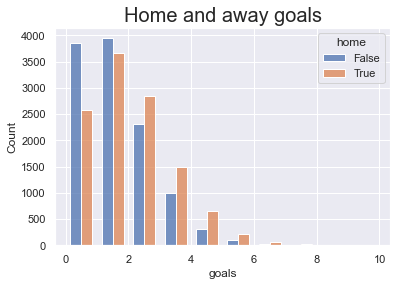

In [284]:
sns.histplot(data=match_data, x="goals", hue="home", multiple="dodge", bins=10,  shrink=.7)
plt.title('Home and away goals', fontsize=20);

Home team tends to score more, and the histogram skews to the right for the home team.

### Using points per game as proxy for performance, is there a relationship between the different metrics and performance?

#### Relationship between points gained and possession
**With home and away teams highlighted**

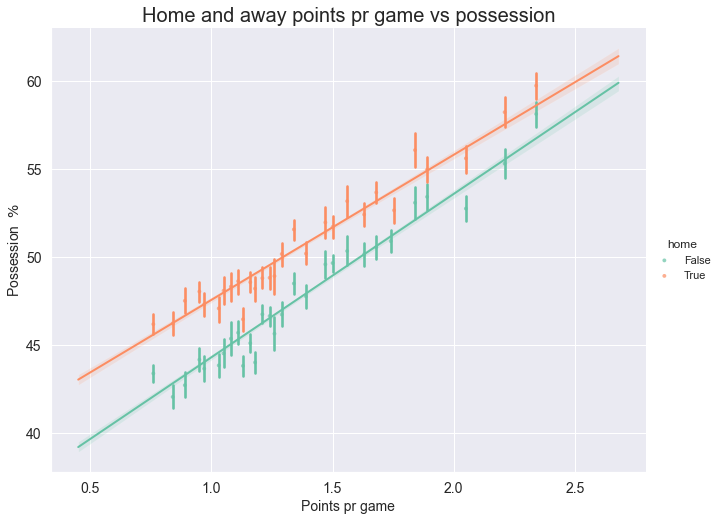

In [205]:
#30 bins for equal number of datapoints, we use linear regression to fit a line through the data.
sns.lmplot(x='points pr game', y='possession', data=match_data, height=7, aspect = 1.3, x_bins=30, hue ='home', fit_reg=True, \
           scatter_kws={'s':15,'edgecolor':'none','alpha':0.7}, line_kws={'lw': 2}, palette='Set2')
plt.title('Home and away points pr game vs possession', fontsize=20);
plt.ylabel("Possession  $\%$" , fontsize=14);
plt.xlabel("Points pr game", fontsize=14);
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

High performing teams tend to keep a lot of the ball, both home and away.  
The opposite is true for the worst performing teams, where they have less than 50%.

#### Relationship between points gained and goals scored
**With home and away teams highlighted**

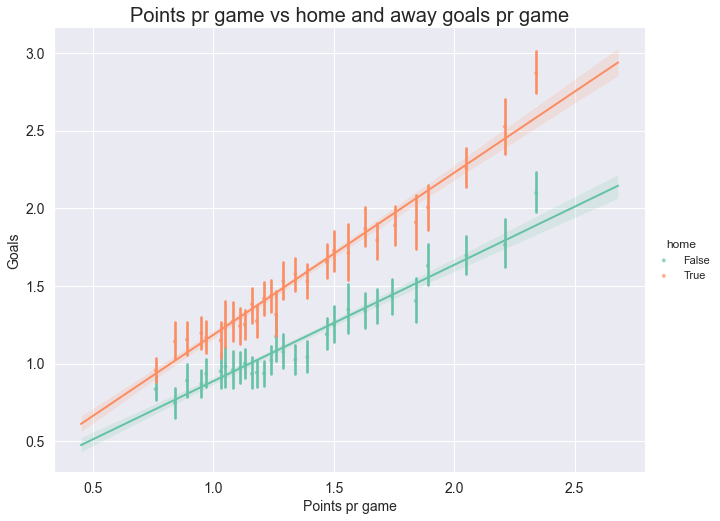

In [254]:
sns.lmplot(x='points pr game', y='goals', data=match_data, height=7, aspect = 1.3, x_bins=30, hue ='home', fit_reg=True, \
           scatter_kws={'s':15,'edgecolor':'none','alpha':0.7}, line_kws={'lw': 2}, palette='Set2')
plt.title('Points pr game vs home and away goals pr game', fontsize=20);
plt.ylabel("Goals", fontsize=14);
plt.xlabel("Points pr game", fontsize=14);
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

There is a strong relationship between goals and points gained.  
At the bottom you have 0.5 goals and 0.5 points pr game, and as you go further to the top right,  
you get a similar values the for home team.


**Relationship between shots on target and goals scored**

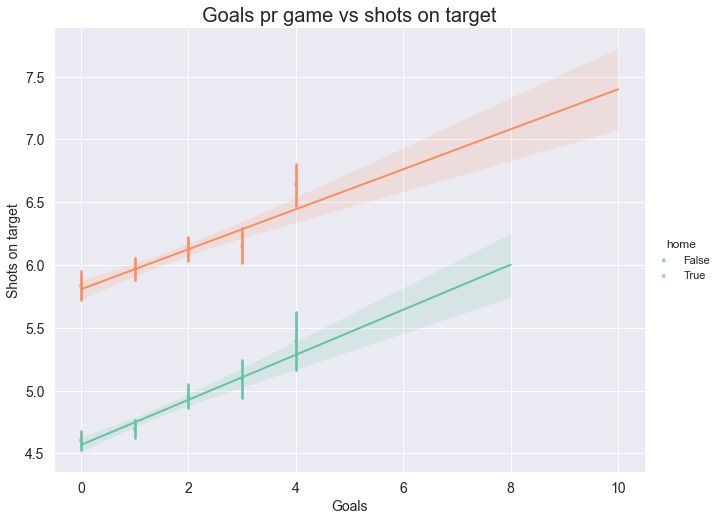

In [257]:
sns.lmplot(x='goals', y='shoton', data=match_data, height=7, aspect = 1.3, x_bins=30, hue ='home', fit_reg=True, \
           scatter_kws={'s':15,'edgecolor':'none','alpha':0.7}, line_kws={'lw': 2}, palette='Set2')
plt.title('Goals pr game vs shots on target', fontsize=20);
plt.xlabel("Goals", fontsize=14);
plt.ylabel("Shots on target", fontsize=14);
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

There is a strong relationship as expected here. We score more the more we shoot.

**Fouls vs points pr game performance**

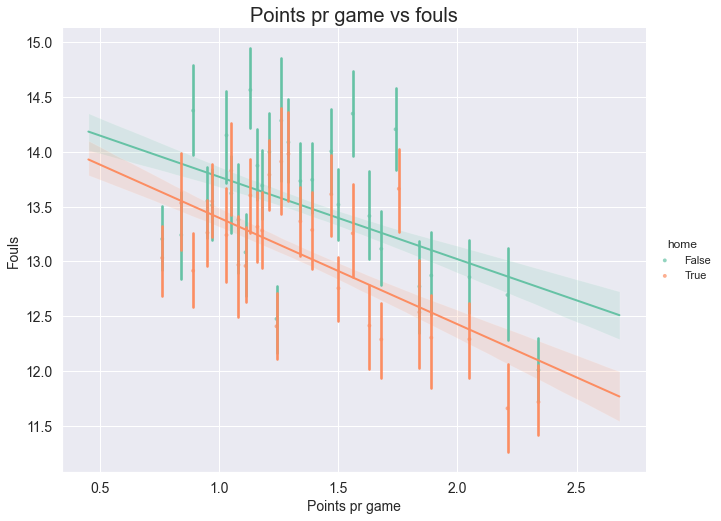

In [260]:
sns.lmplot(x='points pr game', y='foul', data=match_data, height=7, aspect = 1.3, x_bins=30, hue ='home', fit_reg=True, \
           scatter_kws={'s':15,'edgecolor':'none','alpha':0.7}, line_kws={'lw': 2}, palette='Set2')
plt.title('Points pr game vs fouls', fontsize=20);
plt.xlabel("Points pr game", fontsize=14);
plt.ylabel("Fouls", fontsize=14);
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

Teams that are underdogs tend to foul more, either stopping attacks or out of frustration  
if they are losing, they tend to also have less of the ball forcing them to defend more.

### How do the metrics vary between the leagues

In [192]:
leagues = pd.DataFrame(data ={'league_id': [1729, 7809, 10257, 21518],
 'country' : [ 'england', 'germany', 'italy', 'spain']})
match_data = match_data.merge(leagues, on='league_id')

In [208]:
match_data.groupby('country')[['card','foul']].mean()

,card,foul
country,,
england,1.817939,11.044408
germany,1.991844,14.494573
italy,2.491095,14.131391
spain,2.858539,13.627839


In England they give fewer fouls pr game, and fewer cards pr game.  
In Spain you have 2.6 fouls more pr game, but 1 card more pr game.  
In the middle we have Germany being closer to England and Italy to Spain.

In [217]:
fb_df = fb_df.merge(leagues, on='league_id')
fb_df.head()

,position,name,games,win,draw,loss,g_f,g_a,goal_diff,points,league_id,season,id,ppg,country
0,1,Inter,38,25,9,4,70,32,38,84,10257,2008/2009,8636,2.21,italy
1,2,Juventus,38,21,11,6,69,37,32,74,10257,2008/2009,9885,1.95,italy
2,3,AC Milan,38,22,8,8,70,35,35,74,10257,2008/2009,8564,1.95,italy
3,4,Fiorentina,38,21,5,12,53,38,15,68,10257,2008/2009,8535,1.79,italy
4,5,Genoa,38,19,11,8,56,39,17,68,10257,2008/2009,10233,1.79,italy


(1.0, 20.0)

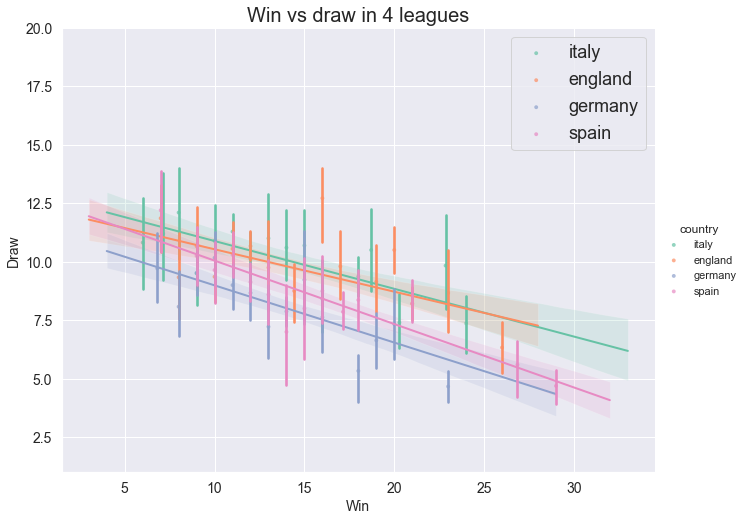

In [230]:
sns.lmplot(x='win', y='draw', data=fb_df, height=7, aspect = 1.3, x_bins=20, hue ='country', fit_reg=True, \
           scatter_kws={'s':15,'edgecolor':'none','alpha':0.7}, line_kws={'lw': 2}, palette='Set2')
plt.title('Win vs draw in 4 leagues', fontsize=20);
plt.xlabel("Win", fontsize=14);
plt.ylabel("Draw", fontsize=14);
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
plt.legend(fontsize='18')
plt.ylim(ymax = 20, ymin = 1)

Approximately the same strategy to the game, we don't see leagues where draws  
are more common than others, resulting in fewer points difference.  
The best and worst teams behave the same across leagues.

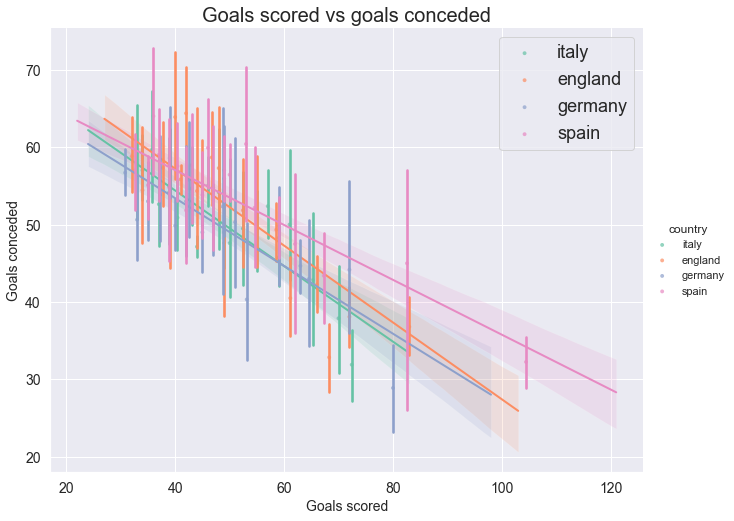

In [262]:
sns.lmplot(x='g_f', y='g_a', data=fb_df, height=7, aspect = 1.3, x_bins=20, hue ='country', fit_reg=True, \
           scatter_kws={'s':15,'edgecolor':'none','alpha':0.7}, line_kws={'lw': 2}, palette='Set2')
plt.title('Goals scored vs goals conceded', fontsize=20);
plt.xlabel('Goals scored', fontsize=14);
plt.ylabel('Goals conceded', fontsize=14);
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
plt.legend(fontsize='18')

#### Who were the best teams in each league during this period?

Spain tends to have high scoring teams, with Italy having more conservative approach.  
England and Germany are in-between. It's expected as in this period Spain was the most  
dominant league, and Italy was on decline after 2010.


In [252]:
fb_df[fb_df['position'] == 1]

,position,name,games,win,draw,loss,g_f,g_a,goal_diff,points,league_id,season,id,ppg,country
0,1,Inter,38,25,9,4,70,32,38,84,10257,2008/2009,8636,2.21,italy
20,1,Inter,38,24,10,4,75,34,41,82,10257,2009/2010,8636,2.16,italy
40,1,AC Milan,38,24,10,4,65,24,41,82,10257,2010/2011,8564,2.16,italy
60,1,Juventus,38,23,15,0,68,20,48,84,10257,2011/2012,9885,2.21,italy
80,1,Juventus,38,27,6,5,71,24,47,87,10257,2012/2013,9885,2.29,italy
100,1,Juventus,38,33,3,2,80,23,57,102,10257,2013/2014,9885,2.68,italy
120,1,Juventus,38,26,9,3,72,24,48,87,10257,2014/2015,9885,2.29,italy
140,1,Juventus,38,29,4,5,75,20,55,91,10257,2015/2016,9885,2.39,italy
160,1,Man Utd,38,28,6,4,68,24,44,90,1729,2008/2009,10260,2.37,england
180,1,Chelsea,38,27,5,6,103,32,71,86,1729,2009/2010,8455,2.26,england


In [247]:
best_teams = fb_df[fb_df['position'] == 1].groupby(['country','name'])[['name']].agg({'name': 'count'})
best_teams = best_teams['name'].sort_values(ascending=False)
best_teams

country  name            
spain    Barcelona           6
germany  FC Bayern           5
italy    Juventus            5
england  Man Utd             3
         Chelsea             2
         Man City            2
germany  Bor. Dortmund       2
italy    Inter               2
england  Leicester           1
germany  VfL Wolfsburg       1
italy    AC Milan            1
spain    Atlético Madrid    1
         Real Madrid         1
Name: name, dtype: int64

Barcelona, FC Bayern, Juventus are the most successful overall, and in their countries.  
In England Manchester United are the most successful with 3, followed by Chelsea and Manchester City with 2 each.  

Juventus winning their 5 in consecutive years, Bayern winning 4 in a row and Barcelona 3 in row.

In [250]:
best_teams_mean = fb_df[fb_df['position'] == 1].groupby(['country','name']).agg({'ppg': 'mean', 'g_f': 'mean', 'g_a': 'mean'})
best_teams_mean['ppg'].sort_values(ascending=False)

country  name            
spain    Real Madrid         2.630000
         Barcelona           2.486667
germany  FC Bayern           2.460000
italy    Juventus            2.372000
spain    Atlético Madrid    2.370000
england  Man City            2.300000
germany  Bor. Dortmund       2.295000
england  Chelsea             2.275000
         Man Utd             2.273333
italy    Inter               2.185000
         AC Milan            2.160000
england  Leicester           2.130000
germany  VfL Wolfsburg       2.030000
Name: ppg, dtype: float64

Real Madrid despite their 1 win, won with most points pr game, followed by Barcelona and FC Bayern.

<a id='conclusions'></a>
## Conclusions

We wanted to know if there was relationship between performance and the match variables we had.  
And we found that there is as relationship between high performance and possession, shots, goals, not fouling.  

Better teams are better at doing everything right, rather than there being teams that are good at one thing and  
terrible at others being successful.

We wanted to look at if playing at home is a major advantage, and we found that there is, in all the measurements,  
including the referees behavior in calling more fouls for the visiting side and carding them more frequently.  

Last we wanted to know the teams that are successful in their leagues in this period.  
There weren't any surprises as the teams that tend to dominate the leagues stay around and build on that for years.  

We had to fill in missing data, ideally each team would have enough data points where filling with mean would work well enough.  
Unfortunately we had whole seasons missing for some teams and had to use the means for their position.  For those that had few
data points,   
the means only reflects those few random matches rather than the mean of their performance that season.

### Limitations

During these years all the leagues had their games filmed and broadcast, the data is outthere either commercially  
or if someone wnats to go through and find old articles or match reports.  
The data that is being used in sports these days are more advanced and model rather than just reading data.  

They are used for match analysis, preperation and improving individual players. It's difficult to do too much with this data.  
We don't know which defender in a given team is preventing opponents attacks from succeeding. Or goalkeepers outside of goals  
conceded. Players positioning, sprints, tackles and more is missing.

I set out to look for trends among team performances as we have useful team metrics and too few player metrics.  
If you want to know how likely teams are to score, defend well and win, this is pretty good data to work with.  

The leagues I picked weren't too difficult to create a table for, but the issue with leagues over long periods is that they don't keep the same rules for tie breakers or even league format. So while you can get decent guess out of points pr game,
you have to be careful with deciding who finished in what position.

## tools
sqlitebrowser  
notepad++  
beautifulsoup  
Chrome + XML reader


**source:** 
Scraping:  
https://fcpython.com/blog/introduction-scraping-data-transfermarkt
  
filling dataframe:  
https://stackoverflow.com/questions/19966018/pandas-filling-missing-values-by-mean-in-each-group
  
linear regression:  
https://github.com/mcleonard/blog_posts/blob/master/body_fat_percentage.ipynb
  
https://medium.com/analytics-vidhya/linear-regression-using-pandas-numpy-for-beginners-in-data-science-fe57157ed93d

In [292]:
##SQL code:
## teams in top 4 leagues
"""
WITH home_team AS (
    SELECT t.team_api_id id, t.team_long_name h_name
    FROM Team t
    ),
    away_team AS (
        SELECT h.id, h.h_name a_name FROM home_team h
    )

SELECT DISTINCT l.name, h.h_name team_name, h.id
FROM Match m
JOIN League l
	ON m.league_id = l.id
	AND l.id IN (1729, 10257, 7809, 21518)
JOIN home_team h
	ON m.home_team_api_id = h.id
ORDER BY l.id, h.id 

#match data

SELECT league_id, season, stage, m.date, match_api_id, home_team_api_id,
away_team_api_id, h.h_name, a.a_name, home_team_goal,away_team_goal
, goal, shoton, shotoff, foulcommit, card, cross, corner, possession 
FROM Match m
JOIN League l
	ON m.league_id = l.id
	AND l.id IN (1729, 10257, 7809, 21518)
JOIN home_team h
ON m.home_team_api_id = h.id
JOIN away_team a
ON m.away_team_api_id = a.id
""";

In [285]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

1